# **Business Data Science Project - Inside Airbnb (multi-city listings, reviews, calendars)**
### by Anastasia Bouev-Dombre, Arthur Morvan, Aliénor Sabourdin, Elise Deyris

## Objective: Smarter pricing (predict how price affects bookings)


*   Idea: If a night is too expensive, fewer people book; too cheap, you leave money on the table.
* What we build: A model that predicts, for each date, how likely a night is to be booked at a given price.
* Output: Recommended price per date (e.g., “15 July: price ≈ 120 for ≈ 80% booking probability”).

For the first part concerning **Data Collection & Cleaning**
We will:
- Load the three CSV files(listings, calendar, reviews), we decided to focus on the city of Bordeaux, France.
- Inspect their structure
- Handle missing values (especially prices and reviews)
- Normalize price and availability fields
- Perform basic geospatial cleaning (coordinates and neighbourhood mapping)
- Export cleaned datasets for later feature engineering and modeling.

In [3]:
# !pip install -r requirements.txt

## Hyperparameters

In [4]:
LISTINGS_PATH = "data/Airbnb-Listings-Data.csv.gz"
CALENDAR_PATH = "data/Airbnb-Calendar-Data.csv.gz"
REVIEWS_PATH = "data/Airbnb-Reviews.csv.gz"


## Imports

In [5]:
#imports and paths
import pandas as pd
import numpy as np

# Import additional visualization libraries
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns

import json
import re

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score, brier_score_loss, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Cleaning

### Overview

In [7]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

In [8]:

listings_raw= pd.read_csv(LISTINGS_PATH)
calendar_raw= pd.read_csv(CALENDAR_PATH)
reviews_raw = pd.read_csv(REVIEWS_PATH)

print("Listings shape:", listings_raw.shape)
print("Calendar shape:", calendar_raw.shape)
print("Reviews shape:", reviews_raw.shape)


Listings shape: (12383, 79)
Calendar shape: (4519796, 7)
Reviews shape: (449626, 6)


In [9]:
#displaying csv files info
print("\nListings head:")
display(listings_raw.head())
print("\nCalendar head:")
display(calendar_raw.head())
print("\nReviews head:")
display(reviews_raw.head())
print("\nListings info:")
listings_raw.info()
print("\nCalendar info:")
calendar_raw.info()
print("\nReviews info:")
reviews_raw.info()


Listings head:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,222887,https://www.airbnb.com/rooms/222887,20250615022817,2025-06-26,city scrape,"Spectacular view, full air-con, elevator",Imagine yourself relaxing on a 12m² private te...,✔ NEARBY MARKETS – Located near St Michel anti...,https://a0.muscache.com/pictures/8f2b210e-3c0e...,1156398,https://www.airbnb.com/users/show/1156398,Suzanne,2011-09-14,"Duras, France","Originally from New Zealand, I now divide my t...",within an hour,100%,94%,t,https://a0.muscache.com/im/pictures/user/User/...,https://a0.muscache.com/im/pictures/user/User/...,Hôtel de Ville - Quinconces,25,31,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Bordeaux Sud,Bordeaux,44.836102,-0.566395,Entire vacation home,Entire home/apt,4,1.0,1 bath,2.0,3.0,"[""Shower gel"", ""Blender"", ""Waterfront"", ""Paid ...",$266.00,3,90,3.0,5.0,90.0,90.0,4.6,90.0,NaN,t,2,7,12,248,2025-06-26,127,31,5,77,28,186,49476.0,2012-01-04,2025-06-22,4.83,4.83,4.75,4.90,4.96,4.75,4.69,3306300031048,t,4,4,0,0,0.77
1,247452,https://www.airbnb.com/rooms/247452,20250615022817,2025-06-26,city scrape,"Cosy apartment ,barbecue, pool",NaN,NaN,https://a0.muscache.com/pictures/39503733/4b3c...,959918,https://www.airbnb.com/users/show/959918,Krista,2011-08-12,"Bordeaux, France","Hi, I'm Krista, 53 years old, Belgian and livi...",within a day,67%,69%,f,https://a0.muscache.com/im/users/959918/profil...,https://a0.muscache.com/im/users/959918/profil...,NaN,1,1,"['email', 'phone']",t,t,NaN,Saint-Mdard-en-Jalles,Saint-Mdard-en-Jalles,44.858900,-0.727350,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,2.0,"[""Private pool"", ""Heating"", ""Wine glasses"", ""W...",$115.00,3,30,3.0,3.0,30.0,30.0,3.0,30.0,NaN,t,24,34,57,147,2025-06-26,79,9,0,147,12,54,6210.0,2012-04-23,2025-04-03,4.73,4.75,4.69,4.96,4.88,4.55,4.61,NaN,f,1,1,0,0,0.49
2,317273,https://www.airbnb.com/rooms/317273,20250615022817,2025-06-26,city scrape,"Luxury, spacious, patio, near public gardens",Bordeaux City Gardens is a luxurious one-bedro...,✔ PRIME LOCATION – Situated near the Bordeaux ...,https://a0.muscache.com/pictures/miso/Hosting-...,1156398,https://www.airbnb.com/users/show/1156398,Suzanne,2011-09-14,"Duras, France","Originally from New Zealand, I now divide my t...",within an hour,100%,94%,t,https://a0.muscache.com/im/pictures/user/User/...,https://a0.muscache.com/im/pictures/user/User/...,Hôtel de Ville - Quinconces,25,31,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Chartrons - Grand Parc - Jardin Public,Bordeaux,44.847801,-0.581046,Entire rental unit,Entire home/apt,3,1.5,1.5 baths,1.0,2.0,"[""Paid parking garage 


Calendar head:


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,222887,2025-06-26,f,NaN,NaN,3,90
1,222887,2025-06-27,f,NaN,NaN,3,90
2,222887,2025-06-28,f,NaN,NaN,3,90
3,222887,2025-06-29,t,NaN,NaN,3,90
4,222887,2025-06-30,f,NaN,NaN,5,90



Reviews head:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,222887,836020,2012-01-04,960075,Marjon,Suzanna's apartment is amazing and it was a tr...
1,222887,2717072,2012-10-25,2887504,Trevor,Great communication & directions from railway...
2,222887,2994458,2012-11-30,405763,William,Fabulous location over Bordeaux and manager ve...
3,222887,3561127,2013-02-17,169773,Daniel,Location is always a must for us and this plac...
4,222887,4230818,2013-04-21,4415172,Sue,This apartment is delightful. Thoughtfully an...



Listings info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12383 entries, 0 to 12382
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12383 non-null  int64  
 1   listing_url                                   12383 non-null  object 
 2   scrape_id                                     12383 non-null  int64  
 3   last_scraped                                  12383 non-null  object 
 4   source                                        12383 non-null  object 
 5   name                                          12383 non-null  object 
 6   description                                   12095 non-null  object 
 7   neighborhood_overview                         6032 non-null   object 
 8   picture_url                                   12383 non-null  object 
 9   host_id                                      

Remarks:

* Price formatting: In the listings dataset, the price column is stored as strings like "$266.00" and contains missing values. We will convert it to numeric format and handle the missing entries.

* Boolean fields:host_is_superhost, host_has_profile_pic, and instant_bookable appear as "t,f". We will transform them in proper boolean values

* Missing values in texts: neighborhood_overview, host_about, and description have many missing values,  We will decide whether to impute them or ignore them for modeling

* Missing numeric values:bedrooms, beds, and bathrooms contain missing values

* Dates stored as strings: last_scraped, host_since, first_review... will be converted to proper datetime objects

* Geospatial cleaning: Since latitude and longitude are complete, we will filter listings to keep only those located within the Bordeaux area.

### Cleaning Listings Data

- Load the CSV file
- Clean the price column
- Filter to Bordeaux city boundaries (geospatial)
- Parse date columns to datetime
- Convert boolean columns
- Clean percentage columns
- Handle amenities and host_verifications (count items)
- Parse bathrooms column (extract numeric)
- Impute missing important numeric, categorical, and text values
- Format ID columns as strings
- Create date features (month, day of week)
- Remove duplicate listings

#### Functions

In [10]:
def bordeaux_bound(df, lat_col="latitude", lon_col="longitude"):
    mask = (df[lat_col].between(44.792, 44.890)) & (df[lon_col].between(-0.620, -0.520))
    return df[mask]

def map_tf_to_bool(series):
    return series.map({'t': True, 'f': False, 'True': True, 'False': False}).astype('boolean')

def clean_percentage(series):
    return series.str.replace('%', '', regex=False).astype(float)

def count_items(x):
    if pd.isna(x) or x in ['[]', '']:
        return 0
    try:
        items = json.loads(x.replace("'", '"'))
        return len(items)
    except:
        return x.count(',') + 1
    
def parse_bathrooms(text):
    if pd.isna(text): return None
    t = str(text).lower()
    if 'half' in t: return 0.5
    m = re.search(r'(\d+(\.\d+)?)', t)
    if m: return float(m.group(1))
    return None

#### Execution

In [11]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!! petite modif ici puisquón avait déjà load le dataset !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
listings = listings_raw.copy()

In [12]:
# remove irrelevant columns that can be confusing for our upcoming analysis
columns_to_remove = [
    # URLs and images aren't needed
    'listing_url', 'host_url', 'picture_url', 
    'host_thumbnail_url', 'host_picture_url',
    
    # text fields that are irrelevant for our analysis
    'description', 'neighborhood_overview', 'host_about', 'name',
    'host_id', 'host_name', 'host_location', 'license',
    
    # redundant columns (we have cleaned/aggregated versions)
    'bathrooms_text',  # we have bathrooms_clean
    'bathrooms',  # we have bathrooms_clean
    'amenities',  # we have amenities_count
    'host_verifications',  # we have host_verifications_count
    'latitude', 'longitude', # dropping latitude and longitude columns as we won't use them, we will rather refer to the neighborhood.
    
    # metadata that is not needed
    'scrape_id', 'source', 'last_scraped',  
    'calendar_last_scraped', 'calendar_updated',
    
    # redundant date features (we'll create from calendar dates instead)
    'month', 'day_of_week',  # these are from last_scraped, not useful
    
    # redundant availability (we have calendar data for date-level availability)
    'has_availability',  # we have date-level availability in calendar
    
    # other redundant columns
    'host_listings_count',  # we have calculated_host_listings_count
    'host_total_listings_count',  # redundant with calculated_host_listings_count
    'neighbourhood',  # we have neighbourhood_cleansed
    'host_neighbourhood',  # not needed
]

# Remove columns that exist
cols_to_drop = [col for col in columns_to_remove if col in listings.columns]
listings = listings.drop(columns=cols_to_drop)

In [13]:
# Clean the price column
if "price" in listings.columns:
    listings["price"] = listings["price"].replace(r'[\$,]', '', regex=True).astype(float)
    listings["price"] = listings["price"].fillna(listings["price"].median())

In [14]:
# Filter to Bordeaux city boundaries
# Remove listings outside Bordeaux bounding box
if {"latitude", "longitude"} <= set(listings.columns):
    listings =bordeaux_bound(listings)

In [15]:
# data columns in datetime
date_cols = ["last_scraped", "host_since", "first_review","last_review"]
for col in date_cols:
    if col in listings.columns:
        listings[col] = pd.to_datetime(listings[col],errors="coerce")


In [16]:
# convert boolean columns

bool_cols = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified",
    "has_availability", "instant_bookable"
]
for col in bool_cols:
    if col in listings.columns:
        listings[col] = map_tf_to_bool(listings[col])

for col in ['host_response_rate', 'host_acceptance_rate']:
    if col in listings.columns:
        listings[col] = clean_percentage(listings[col])

In [17]:
# handle amenities and host_verifications (count items), parse bathroom column,s


for col in ["amenities", "host_verifications"]:
    if col in listings.columns:
        listings[col] = listings[col].fillna('[]')
        listings[f"{col}_count"] =listings[col].apply(count_items)


if "bathrooms_text" in listings.columns:
    listings["bathrooms_clean"] = listings["bathrooms_text"].apply(parse_bathrooms)
elif "bathrooms" in listings.columns:
    listings["bathrooms_clean"] = pd.to_numeric(listings["bathrooms"], errors="coerce")
    listings["bathrooms_clean"] = listings["bathrooms_clean"].fillna(listings["bathrooms_clean"].median())

In [18]:
# handle missing values
num_cols = ["price", "accommodates", "bedrooms", "beds", "bathrooms_clean"]
for col in num_cols:
    if col in listings.columns:
        listings[col] = listings[col].fillna(listings[col].median())
cat_cols = ["room_type", "property_type", "neighbourhood_cleansed"]
for col in cat_cols:
    if col in listings.columns:
        listings[col] = listings[col].fillna(listings[col].mode()[0])
for col in ["description", "neighborhood_overview", "host_about"]:
    if col in listings.columns:
        listings[col] = listings[col].fillna("")

In [19]:
# format ID columns as strings
for col in ["id", "scrape_id", "host_id"]:
    if col in listings.columns:
        listings[col] = listings[col].astype(str)

In [20]:
# create date features (month, day of week)
if "last_scraped" in listings.columns:
    listings["month"] = listings["last_scraped"].dt.month
    listings["day_of_week"] = listings["last_scraped"].dt.dayofweek

In [21]:
# remove duplicates
if "id" in listings.columns:
    listings = listings.drop_duplicates(subset="id", keep="first")


In [22]:
print("CLEAN SHAPE:", listings.shape)
print(f"Removed {len(cols_to_drop)} irrelevant columns")
print(f"Remaining columns: {listings.shape[1]}")
listings.head()

CLEAN SHAPE: (12383, 50)
Removed 29 irrelevant columns
Remaining columns: 50


,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,222887,2011-09-14,within an hour,100.0,94.0,True,True,True,Bordeaux Sud,Bordeaux,Entire vacation home,Entire home/apt,4,2.0,3.0,266.0,3,90,3.0,5.0,90.0,90.0,4.6,90.0,2,7,12,248,127,31,5,77,28,186,49476.0,2012-01-04,2025-06-22,4.83,4.83,4.75,4.90,4.96,4.75,4.69,True,4,4,0,0,0.77
1,247452,2011-08-12,within a day,67.0,69.0,False,True,True,Saint-Mdard-en-Jalles,Saint-Mdard-en-Jalles,Entire rental unit,Entire home/apt,4,2.0,2.0,115.0,3,30,3.0,3.0,30.0,30.0,3.0,30.0,24,34,57,147,79,9,0,147,12,54,6210.0,2012-04-23,2025-04-03,4.73,4.75,4.69,4.96,4.88,4.55,4.61,False,1,1,0,0,0.49
2,317273,2011-09-14,within an hour,100.0,94.0,True,True,True,Chartrons - Grand Parc - Jardin Public,Bordeaux,Entire rental unit,Entire home/apt,3,1.0,2.0,203.0,3,90,3.0,3.0,90.0,90.0,3.0,90.0,2,11,28,273,80,20,0,100,19,120,24360.0,2014-08-13,2025-04-29,4.90,4.98,4.83,4.96,4.96,4.96,4.78,True,4,4,0,0,0.60
3,317658,2011-09-14,within an hour,100.0,94.0,True,True,True,Centre ville (Bordeaux),Bordeaux,Entire rental unit,Entire home/apt,6,2.0,4.0,222.0,3,90,2.0,5.0,90.0,90.0,4.5,90.0,11,17,27,269,161,17,0,93,21,102,22644.0,2012-03-15,2025-04-28,4.87,4.85,4.83,4.88,4.92,4.97,4.77,True,4,4,0,0,1.00
4,333031,2012-02-04,within an hour,86.0,82.0,True,True,True,Centre ville (Bordeaux),Bordeaux,Entire rental unit,Entire home/apt,2,0.0,1.0,103.0,1,1125,1.0,1.0,1125.0,1125.0,1.0,1125.0,24,54,82,353,556,53,4,178,47,255,26265.0,2012-04-02,2025-06-09,4.92,4.95,4.95,4.95,4.92,4.98,4.83,False,2,1,1,0,3.45


In [23]:
# check missing values
missing_summary = listings.isnull().sum()
missing_summary

id                                                 0
host_since                                         0
host_response_time                              4538
host_response_rate                              4538
host_acceptance_rate                            3644
host_is_superhost                                248
host_has_profile_pic                               0
host_identity_verified                             0
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                       0
property_type                                      0
room_type                                          0
accommodates                                       0
bedrooms                                           0
beds                                               0
price                                              0
minimum_nights                                     0
maximum_nights                                     0
minimum_minimum_nights                        

In [24]:
# Only keep the year for "last_review" and "first_review", we assume the day and the month are not relevant for our analysis
listings['first_review_year'] = listings['first_review'].dt.year
listings = listings.drop(columns=['first_review'])

listings['last_review_year'] = listings['last_review'].dt.year
listings = listings.drop(columns=['last_review'])

# For these columns, we will assume that if the data is missing it is because there has never been any reviews.
# We will therefore fill the missing values with the maximum year found in the dataset plus one (indicating no reviews up to now)
max_year = listings[['first_review_year', 'last_review_year']].max().max()

listings['first_review_year'] = listings['first_review_year'].fillna(max_year)
listings['last_review_year'] = listings['last_review_year'].fillna(max_year)

In [25]:
# we will impute missing values with the median for numerical columns and the mode for categorical columns
# for the boolean columns, we can fill missing values with False

num_cols = listings.select_dtypes(include=['float64', 'int64']).columns
cat_cols = listings.select_dtypes(include=['object', 'category']).columns
bool_cols = listings.select_dtypes(include=['boolean']).columns


for col in num_cols:
    listings[col] = listings[col].fillna(listings[col].median())
for col in cat_cols:
    listings[col] = listings[col].fillna(listings[col].mode()[0])
for col in bool_cols:
    listings[col] = listings[col].fillna(False)


In [26]:
# check missing values
missing_summary = listings.isnull().sum()
missing_summary

id                                              0
host_since                                      0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_cleansed                          0
neighbourhood_group_cleansed                    0
property_type                                   0
room_type                                       0
accommodates                                    0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0


### Cleaning Calendar Data

The calendar data is critical for booking prediction as it contains:
- Date-level availability (available/booked labels)
- Price per date
- Minimum/maximum nights requirements

We will:
- Filter to Bordeaux listings (join with cleaned listings)
- Parse date column to datetime
- Convert available column to boolean
- Handle missing prices (use listing's base price or median)
- Create booking label (booked = not available)
- Remove invalid dates


In [27]:
# --- Load calendar data ---

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!! petite modif ici puisquón avait déjà load le dataset !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
calendar = calendar_raw.copy()

print("Calendar raw shape:", calendar.shape)
print("\nCalendar columns:", calendar.columns.tolist())
print("\nCalendar dtypes:")
print(calendar.dtypes)
print("\nCalendar head:")
display(calendar.head())
print("\nMissing values:")
print(calendar.isnull().sum())
print("\nAvailable values unique:", calendar['available'].unique() if 'available' in calendar.columns else "N/A")


Calendar raw shape: (4519796, 7)

Calendar columns: ['listing_id', 'date', 'available', 'price', 'adjusted_price', 'minimum_nights', 'maximum_nights']

Calendar dtypes:
listing_id          int64
date               object
available          object
price             float64
adjusted_price    float64
minimum_nights      int64
maximum_nights      int64
dtype: object

Calendar head:


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,222887,2025-06-26,f,NaN,NaN,3,90
1,222887,2025-06-27,f,NaN,NaN,3,90
2,222887,2025-06-28,f,NaN,NaN,3,90
3,222887,2025-06-29,t,NaN,NaN,3,90
4,222887,2025-06-30,f,NaN,NaN,5,90



Missing values:
listing_id              0
date                    0
available               0
price             4519796
adjusted_price    4519796
minimum_nights          0
maximum_nights          0
dtype: int64

Available values unique: ['f' 't']


In [28]:
# filter to Bordeaux listings only
calendar['listing_id'] = calendar['listing_id'].astype(str)
bordeaux_listing_ids = set(listings['id'].astype(str))
calendar = calendar[calendar['listing_id'].isin(bordeaux_listing_ids)].copy()

In [29]:
# Separate date column into 'Year', 'Month', 'Day'
calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')

calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['day'] = calendar['date'].dt.day



In [30]:
# convert available to boolean

calendar['available'] = calendar['available'].map({'t': True, 'f': False, 'True': True, 'False': False, True: True, False: False})
calendar['available'] = calendar['available'].astype('boolean')
calendar['is_booked'] = ~calendar['available']  # booked = not available

In [31]:
# handle prices - chain: adjusted_price -> price -> listing price -> median
listings_price_map = listings.set_index('id')['price'].to_dict()
calendar['listing_base_price'] = calendar['listing_id'].map(listings_price_map)

In [32]:
# create price_clean using fillna chain
if 'adjusted_price' in calendar.columns and 'price' in calendar.columns:
    calendar['price_clean'] = calendar['adjusted_price'].fillna(calendar['price']).fillna(calendar['listing_base_price'])
elif 'adjusted_price' in calendar.columns:
    calendar['price_clean'] = calendar['adjusted_price'].fillna(calendar['listing_base_price'])
elif 'price' in calendar.columns:
    calendar['price_clean'] = calendar['price'].fillna(calendar['listing_base_price'])
else:
    calendar['price_clean'] = calendar['listing_base_price']

# fill remaining missing with median
if calendar['price_clean'].notna().sum() > 0:
    calendar['price_clean'] = calendar['price_clean'].fillna(calendar['price_clean'].median())

# drop price column 
calendar = calendar.drop(columns=['price'])

In [33]:
# remove rows with missing prices
calendar = calendar[calendar['price_clean'].notna()].copy()

# clean up
calendar = calendar.dropna(subset=['listing_id', 'available', 'date'])
calendar = calendar.sort_values(['listing_id', 'date']).reset_index(drop=True)

# remove redundant columns
cols_to_remove =['price', 'adjusted_price', 'listing_base_price']
cols_to_remove = [col for col in cols_to_remove if col in calendar.columns]
calendar = calendar.drop(columns=cols_to_remove)


In [34]:
# display results
print(f"Final calendar shape: {calendar.shape}")
print(f"Date range: {calendar['date'].min()} to {calendar['date'].max()}")
print(f"Booking rate: {calendar['is_booked'].mean():.2%}")
print(f"Price range: {calendar['price_clean'].min():.2f} - {calendar['price_clean'].max():.2f}")
calendar.head(30)


Final calendar shape: (4519796, 10)
Date range: 2025-06-25 00:00:00 to 2026-06-26 00:00:00
Booking rate: 61.68%
Price range: 12.00 - 10000.00


,listing_id,date,available,minimum_nights,maximum_nights,year,month,day,is_booked,price_clean
0,1000537871351948755,2025-06-26,False,1,365,2025,6,26,True,76.0
1,1000537871351948755,2025-06-27,False,1,365,2025,6,27,True,76.0
2,1000537871351948755,2025-06-28,False,1,365,2025,6,28,True,76.0
3,1000537871351948755,2025-06-29,True,1,365,2025,6,29,False,76.0
4,1000537871351948755,2025-06-30,True,1,365,2025,6,30,False,76.0
5,1000537871351948755,2025-07-01,False,1,365,2025,7,1,True,76.0
6,1000537871351948755,2025-07-02,True,1,365,2025,7,2,False,76.0
7,1000537871351948755,2025-07-03,True,1,365,2025,7,3,False,76.0
8,1000537871351948755,2025-07-04,True,1,365,2025,7,4,False,76.0
9,1000537871351948755,2025-07-05,True,1,365,2025,7,5,False,76.0


In [35]:
# check missing values
missing_summary = calendar.isnull().sum()
missing_summary

listing_id        0
date              0
available         0
minimum_nights    0
maximum_nights    0
year              0
month             0
day               0
is_booked         0
price_clean       0
dtype: int64

### Clean Reviews Data

We will:
- Filter to Bordeaux listings 
- Parse date column to datetime
- Handle missing prices 
- Sort by listing_id and date
- Remove irrelevant columns


In [36]:
# --- Load reviews data ---

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!! petite modif ici puisquón avait déjà load le dataset !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
reviews = reviews_raw.copy()
# reviews = pd.read_csv(REVIEWS_PATH)

print("Reviews raw shape:", reviews.shape)
print("\nReviews columns:", reviews.columns.tolist())
print("\nReviews dtypes:")
print(reviews.dtypes)
print("\nMissing values:")
print(reviews.isnull().sum())
print("\nReviews head:")
display(reviews.head())


Reviews raw shape: (449626, 6)

Reviews columns: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']

Reviews dtypes:
listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

Missing values:
listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         9
dtype: int64

Reviews head:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,222887,836020,2012-01-04,960075,Marjon,Suzanna's apartment is amazing and it was a tr...
1,222887,2717072,2012-10-25,2887504,Trevor,Great communication & directions from railway...
2,222887,2994458,2012-11-30,405763,William,Fabulous location over Bordeaux and manager ve...
3,222887,3561127,2013-02-17,169773,Daniel,Location is always a must for us and this plac...
4,222887,4230818,2013-04-21,4415172,Sue,This apartment is delightful. Thoughtfully an...


In [37]:
# --- Clean Reviews Data ---

# filter to Bordeaux listings only
reviews['listing_id'] = reviews['listing_id'].astype(str)
reviews = reviews[reviews['listing_id'].isin(bordeaux_listing_ids)].copy()

print(f"Reviews after filtering to Bordeaux: {reviews.shape}")

# parse date column to datetime
if 'date' in reviews.columns:
    reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
    # Remove rows with invalid dates
    reviews = reviews[reviews['date'].notna()].copy()

# handle missing comments (fill with empty string for now, can be used for sentiment analysis later)
if 'comments' in reviews.columns:
    reviews['comments'] = reviews['comments'].fillna('')


# remove any remaining invalid rows
reviews = reviews.dropna(subset=['listing_id', 'date'])

# sort by listing_id and date
reviews = reviews.sort_values(['listing_id', 'date']).reset_index(drop=True)

# remove irrelevant columns
columns_to_remove_reviews = [
    'reviewer_name',  # not needed for modeling
    'reviewer_id',  # not needed unless analyzing reviewer behavior
    'id',  # review ID not needed (we have listing_id and date)
]

cols_to_drop_rev = [col for col in columns_to_remove_reviews if col in reviews.columns]
reviews = reviews.drop(columns=cols_to_drop_rev)

print(f"\nFinal reviews shape: {reviews.shape}")
print(f"Removed {len(cols_to_drop_rev)} irrelevant columns")
print(f"\nDate range:{reviews['date'].min()} to {reviews['date'].max()}")
print(f"\nReviews with comments: {(reviews['comments'].str.strip() != '').sum()}")
print(f"\nSample of cleaned reviews:")
reviews.head(10)


Reviews after filtering to Bordeaux: (449626, 6)

Final reviews shape: (449626, 3)
Removed 3 irrelevant columns

Date range:2012-01-04 00:00:00 to 2025-06-26 00:00:00

Reviews with comments: 449617

Sample of cleaned reviews:


,listing_id,date,comments
0,1000537871351948755,2023-11-19,Tout s’est très bien passé ! Appartement très ...
1,1000537871351948755,2023-11-26,Ha sido un placer alojarnos con Camille.<br/>H...
2,1000537871351948755,2023-12-10,Je remercie Camille pour son accueil dans l'ap...
3,1000537871351948755,2023-12-15,J'ai passé un court mais excellent sejour chez...
4,1000537871351948755,2024-02-04,Hôte disponible <br/>Logement très accueillant...
5,1000537871351948755,2024-02-18,"Hôte très accueillante , très disponible , log..."
6,1000537871351948755,2024-03-19,"Airbnb, parfait, j’y retournerai sans hésiter !"
7,1000537871351948755,2024-04-02,Merci à Camille pour ce séjour fabuleux ! Le l...
8,1000537871351948755,2024-04-28,"Nous avons passé deux nuits à l'échoppe, l'env..."
9,1000537871351948755,2024-05-06,"Super séjour à l’échoppe, très spacieux et bie..."


In [38]:
# Summuary of Cleaned Datasets


print(f"LISTINGS:")
print(f"Shape: {listings.shape}")
print(f"   Key columns: id, host_id, price, room_type, property_type,")
print(f"                accommodates, bedrooms, beds, bathrooms_clean,")
print(f"                amenities_count, neighbourhood_cleansed, latitude, longitude,")
print(f"                review_scores_*, host_metrics,...")

print("\n")
print(f"CALENDAR:")
print(f"   Shape: {calendar.shape}")
print(f"   Key columns: listing_id, date, available, is_booked, price_clean,")
print(f"                minimum_nights, maximum_nights")

print("\n")
print(f"REVIEWS:")
print(f"   Shape: {reviews.shape}")
print(f"   Key columns: listing_id, date, comments")



LISTINGS:
Shape: (12383, 50)
   Key columns: id, host_id, price, room_type, property_type,
                accommodates, bedrooms, beds, bathrooms_clean,
                amenities_count, neighbourhood_cleansed, latitude, longitude,
                review_scores_*, host_metrics,...


CALENDAR:
   Shape: (4519796, 10)
   Key columns: listing_id, date, available, is_booked, price_clean,
                minimum_nights, maximum_nights


REVIEWS:
   Shape: (449626, 3)
   Key columns: listing_id, date, comments


### Summary of Data Cleaning

**Listings Data**: Cleaned and filtered to Bordeaux 
- Price normalized, dates parsed, booleans converted, missing values handled, duplicates removed

**Calendar Data**: Cleaned and filtered to Bordeaux listings, 
- Date level availability and prices ready for booking prediction, booking labels created (is_booked = not available), missing prices handled

**Reviews Data**: Cleaned and filtered to Bordeaux listings
- Ready for review-based feature engineering

# Merging & Feature Engineering

Workflow for this step is the following: 

1. Merge data
2. Drop 'de facto' useless columns
3. Handle missing values (both numerical & categorical) ------------------------- (je rajoute ça chez Élise plutôt)
4. Encode categorical variables (one-hot/ordinal)
5. Calculate VIF on all features (numerical + encoded categorical)
6. Iteratively remove high VIF variables

And then we will be ready for the next step, prediction.

### Overview

Just getting a grasp of what we are dealing with. We want to merge the datasets. We need the listings to correspond to the calendar dates. 

Here are the columns that we have in the listings and in the calendar datasets:

In [39]:
# compare columns of the three datasets
print("Listings columns:", set(listings.columns))
print("Calendar columns:", set(calendar.columns))
print("Reviews columns:", set(reviews.columns))

Listings columns: {'availability_30', 'host_identity_verified', 'accommodates', 'maximum_maximum_nights', 'number_of_reviews_ly', 'instant_bookable', 'last_review_year', 'minimum_nights_avg_ntm', 'calculated_host_listings_count', 'room_type', 'host_acceptance_rate', 'review_scores_checkin', 'review_scores_location', 'minimum_nights', 'estimated_occupancy_l365d', 'host_has_profile_pic', 'neighbourhood_cleansed', 'review_scores_cleanliness', 'availability_eoy', 'estimated_revenue_l365d', 'availability_90', 'host_response_time', 'id', 'price', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_communication', 'maximum_nights', 'calculated_host_listings_count_private_rooms', 'maximum_nights_avg_ntm', 'beds', 'minimum_minimum_nights', 'host_since', 'neighbourhood_group_cleansed', 'review_scores_value', 'first_review_year', 'bedrooms', 'number_of_reviews', 'calculated_host_listings_count_entire_homes', 'review_scores_rating', 'minimum_maximum_nights', 'host_response_rate', 'c

To get an idea of how we are going to perform the merge, let's see how listings are represented in the different datasets:

In [40]:
# get the rows in each dataset where "id" or "listing_id" is equal to '1605871'
print("\nListings row for id '1605871':")
display(listings[listings['id'] == '1605871'])
print("\nCalendar rows for listing_id '1605871':")
display(calendar[calendar['listing_id'] == '1605871'])
print("\nReviews rows for listing_id '1605871':")
display(reviews[reviews['listing_id'] == '1605871'])


Listings row for id '1605871':


,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,first_review_year,last_review_year
88,1605871,2013-08-31,within an hour,100.0,95.0,False,True,False,Saint Augustin - Tauzin - Alphonse Dupeux,Bordeaux,Entire condo,Entire home/apt,3,1.0,2.0,47.0,3,28,3.0,14.0,1125.0,1125.0,3.4,1125.0,4,25,54,54,124,0,0,54,0,0,0.0,4.67,4.8,4.73,4.87,4.89,4.48,4.65,False,1,1,0,0,0.94,2014.0,2021.0



Calendar rows for listing_id '1605871':


,listing_id,date,available,minimum_nights,maximum_nights,year,month,day,is_booked,price_clean
1600525,1605871,2025-06-25,False,3,1125,2025,6,25,True,47.0
1600526,1605871,2025-06-26,False,3,1125,2025,6,26,True,47.0
1600527,1605871,2025-06-27,False,3,1125,2025,6,27,True,47.0
1600528,1605871,2025-06-28,False,3,1125,2025,6,28,True,47.0
1600529,1605871,2025-06-29,False,3,1125,2025,6,29,True,47.0
...,...,...,...,...,...,...,...,...,...,...
1600885,1605871,2026-06-20,False,3,1125,2026,6,20,True,47.0
1600886,1605871,2026-06-21,False,3,1125,2026,6,21,True,47.0
1600887,1605871,2026-06-22,False,3,1125,2026,6,22,True,47.0
1600888,1605871,2026-06-23,False,3,1125,2026,6,23,True,47.0



Reviews rows for listing_id '1605871':


,listing_id,date,comments
89048,1605871,2014-09-04,Lovely apartment. Close to bus line which take...
89049,1605871,2014-09-06,Lovely clean apartment. Well equipped with eve...
89050,1605871,2015-04-30,Très bon accueil. Ghislaine est toujours dispo...
89051,1605871,2015-05-10,Nous avons loué cet appartement pour 2 nuits ;...
89052,1605871,2015-05-17,"Appartement très agréable, propre et calme\r<b..."
...,...,...,...
89167,1605871,2020-02-24,L'appartement dans un ensemble d'immeubles dan...
89168,1605871,2020-03-01,Parfaitement conforme aux attentes. Je recomma...
89169,1605871,2021-11-02,L’appartement était un peu éloigné du centre v...
89170,1605871,2021-11-09,Emplacement parfait pour notre séjour dans cet...


### Merging

Listings:
- We have one listing ID (column "id") per row in the listings dataset. "id" serves here as a primary key.

Calendar:
-  We have 365 times the same "listing_id" in the dataset. This is because the dataset actually has one row for each day of the year for a certain apartment. The primary key in this table is a composite key made up of "listing_id" and "date".

We will therefore perform a left join from the listings dataset to the calendar dataset, in order to still have the availability of a certain listing for each fay of the year. 

In [41]:
# Perform the left join

merged_df = listings.merge(
    calendar,
    left_on='id',           # Column in listings_df
    right_on='listing_id',  # Column in calendar_df
    how='left'              # Left join
)

print("Calendar shape:", calendar.shape)
print("Listings shape:", listings.shape)
print("Merged DataFrame shape:", merged_df.shape)

Calendar shape: (4519796, 10)
Listings shape: (12383, 50)
Merged DataFrame shape: (4519796, 60)


Merged dataframe:
- So the number of columns is equal to the sum of the number of columns in both datasets. 
- The number of rows is equal to the number of rows in the calendar dataframe.

### Further Cleaning

Let's further clean the merged dataset before proceeding to the feature engineering part.

In [42]:
# creating a copy of merged_df we might refer to later, to check geographical coordinatates fro instance.
merged_df_clean_copy = merged_df.copy()

In [43]:
# lsiting all the columns in the merged dataframe
print("Merged DataFrame columns:", merged_df.columns.tolist())
# merged_df.head()

Merged DataFrame columns: ['id', 'host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_x', 'maximum_nights_x', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count'

In [44]:
# dropping columns "listing_id" as it is now redundant with "id"
merged_df = merged_df.drop(columns=['listing_id'])

# dropping columns "minimum_nights_y" and "maximum_nights_y" as they are redundant with "minimum_nights_x" and "maximum_nights_x"
merged_df = merged_df.drop(columns=['minimum_nights_y', 'maximum_nights_y'])

# renaming columns to have consistent names
merged_df = merged_df.rename(columns={'minimum_nights_x': 'minimum_nights', 'maximum_nights_x': 'maximum_nights'})

In [45]:
# Only keep the year for "host since", we assume the day and the month are not relevant for our analysis

merged_df['host_since_year'] = merged_df['host_since'].dt.year
merged_df = merged_df.drop(columns=['host_since'])

In [46]:
# room_type column is more relevant than property_type for our analysis, so we drop property_type
merged_df = merged_df.drop(columns=['property_type'])

In [47]:
# drop the date column as we have already extracted year, month and day from it
merged_df = merged_df.drop(columns=['date'])

In [48]:
# drop id as it is not relevant for our analysis
merged_df = merged_df.drop(columns=['id'])

In [49]:
# let's drop neighbourhood_cleansed, we will only base ourself on neighbourhood_group_cleansed, which is less granular but still has 28 distinct categories
merged_df = merged_df.drop(columns=['neighbourhood_cleansed'])

In [50]:
# drop 'available' because it has a correlation of -1 with 'is_booked'
merged_df = merged_df.drop(columns=['available'])

In [51]:
# drop these because we already have minimum_nights and maximum_nights
merged_df = merged_df.drop(columns=['maximum_minimum_nights'])
merged_df = merged_df.drop(columns=['minimum_minimum_nights'])
merged_df = merged_df.drop(columns=['maximum_maximum_nights'])
merged_df = merged_df.drop(columns=['minimum_maximum_nights'])
merged_df = merged_df.drop(columns=['minimum_nights_avg_ntm'])
merged_df = merged_df.drop(columns=['maximum_nights_avg_ntm'])

In [52]:
# drop these because we already have the availability for the past 30 days
merged_df = merged_df.drop(columns=['availability_eoy'])
merged_df = merged_df.drop(columns=['availability_60'])
merged_df = merged_df.drop(columns=['availability_90'])
merged_df = merged_df.drop(columns=['availability_365'])

In [53]:
# drop these because we already have the overall review score
merged_df = merged_df.drop(columns=['review_scores_accuracy'])
merged_df = merged_df.drop(columns=['review_scores_cleanliness'])
merged_df = merged_df.drop(columns=['review_scores_value'])
merged_df = merged_df.drop(columns=['review_scores_checkin'])
merged_df = merged_df.drop(columns=['review_scores_communication'])

In [54]:
merged_df = merged_df.drop(columns=['number_of_reviews'])
merged_df = merged_df.drop(columns=['number_of_reviews_ltm'])

In [55]:
merged_df = merged_df.drop(columns=['calculated_host_listings_count_entire_homes'])
merged_df = merged_df.drop(columns=['calculated_host_listings_count_private_rooms'])
merged_df = merged_df.drop(columns=['calculated_host_listings_count_shared_rooms'])

In [56]:
# drop because it is highly correlated with the number of reviews during the past year
merged_df = merged_df.drop(columns=['estimated_occupancy_l365d'])


In [57]:
# drop because it is highly correlated with the number of bedrooms
merged_df = merged_df.drop(columns=['accommodates'])

In [58]:
print(len(merged_df.columns))

30


In [59]:
# print unique values in each column
for col in merged_df.columns:
    unique_values = merged_df[col].nunique()
    print(f"Column '{col}' has {unique_values} unique values.")

Column 'host_response_time' has 4 unique values.
Column 'host_response_rate' has 61 unique values.
Column 'host_acceptance_rate' has 101 unique values.
Column 'host_is_superhost' has 2 unique values.
Column 'host_has_profile_pic' has 2 unique values.
Column 'host_identity_verified' has 2 unique values.
Column 'neighbourhood_group_cleansed' has 28 unique values.
Column 'room_type' has 4 unique values.
Column 'bedrooms' has 10 unique values.
Column 'beds' has 16 unique values.
Column 'price' has 472 unique values.
Column 'minimum_nights' has 48 unique values.
Column 'maximum_nights' has 124 unique values.
Column 'availability_30' has 31 unique values.
Column 'number_of_reviews_l30d' has 21 unique values.
Column 'number_of_reviews_ly' has 131 unique values.
Column 'estimated_revenue_l365d' has 1919 unique values.
Column 'review_scores_rating' has 120 unique values.
Column 'review_scores_location' has 121 unique values.
Column 'instant_bookable' has 2 unique values.
Column 'calculated_host

### Encoding

Encoding certain values will help us 

In [60]:
df_encoded = merged_df.copy()

Encoding boolean variables

In [61]:
boolean_cols = [
    'host_is_superhost',
    'host_has_profile_pic', 
    'host_identity_verified',
    'instant_bookable',
    'is_booked'
]

for col in boolean_cols:
    df_encoded[col] = df_encoded[col].astype(int)

print(f"\nEncoded {len(boolean_cols)} boolean columns to 0/1")



Encoded 5 boolean columns to 0/1


Encoding ordinal variables

In [62]:
# check categories
print(df_encoded['host_response_time'].value_counts())

# Map based on actual categories
response_time_mapping = {
    'within an hour': 0,
    'within a few hours': 1,
    'within a day': 2,
    'a few days or more': 3,
}

df_encoded['host_response_time'] = df_encoded['host_response_time'].map(response_time_mapping)

print("\nEncoded host_response_time (ordinal)")

host_response_time
within an hour        3527726
within a few hours     553705
within a day           327040
a few days or more     111325
Name: count, dtype: int64

Encoded host_response_time (ordinal)


One-hot encoding for categorical variables. The difference between these and the ordinal encoding is that these variables have no meaningful order in their values.

In [63]:
nominal_cols = [
    'neighbourhood_group_cleansed',
    'room_type'
]

print(f"\nOne-hot encoding {len(nominal_cols)} categorical columns")

# Check nb of categories
for col in nominal_cols:
    n_categories = df_encoded[col].nunique()
    print(f"  {col}: {n_categories} categories -> {n_categories-1} dummy columns")

# encoding
df_encoded = pd.get_dummies(
    df_encoded,
    columns=nominal_cols,
    drop_first=True,  # Avoid dummy variable trap where one category can be perfectly predicted from others
    dtype=int
)

print(f"\nAfter encoding, total columns: {df_encoded.shape[1]}")



One-hot encoding 2 categorical columns
  neighbourhood_group_cleansed: 28 categories -> 27 dummy columns
  room_type: 4 categories -> 3 dummy columns

After encoding, total columns: 58


Final check that everything is well encoded.

In [64]:

print("VERIFICATION ------------------------------------- ")

# Check data types
print("\nData types after encoding:")
print(df_encoded.dtypes.value_counts())

# Check for any remaining non-numeric columns
non_numeric = df_encoded.select_dtypes(exclude=['number']).columns.tolist()
if non_numeric:
    print(f"\nWARNING: Non-numeric columns still present: {non_numeric}")
else:
    print("\n✓ All columns are numeric")

# Check for missing values
missing_count = df_encoded.isnull().sum().sum()
if missing_count > 0:
    print(f"\nWARNING: {missing_count} missing values still present")
    print("\nMissing values by column:")
    print(df_encoded.isnull().sum()[df_encoded.isnull().sum() > 0])
else:
    print("✓ No missing values")

# Check for infinite values
inf_count = np.isinf(df_encoded.select_dtypes(include=['float64', 'int64'])).sum().sum()
if inf_count > 0:
    print(f"\nWARNING: {inf_count} infinite values present")
else:
    print("✓ No infinite values")

print("\nREADY FOR VIF ANALYSIS ")
print(f"Final shape: {df_encoded.shape}")
print(f"Columns: {df_encoded.columns.tolist()[:10]}... (showing first 10)")


VERIFICATION ------------------------------------- 

Data types after encoding:
int64      42
float64    12
int32       4
Name: count, dtype: int64

✓ All columns are numeric
✓ No missing values
✓ No infinite values

READY FOR VIF ANALYSIS 
Final shape: (4519796, 58)
Columns: ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'bedrooms', 'beds', 'price', 'minimum_nights']... (showing first 10)


### Splitting features from target (price prediction)

#### Functions

In [65]:
def target_features(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

def to_drop_highly_correlated_features(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.9)]
    return to_drop

def create_sample(X, sample_size=200000):
    np.random.seed(42)
    sample_idx = np.random.choice(X.index, size=sample_size, replace=False)     # draw at random without replacement
    X_sample = X.loc[sample_idx]
    return X_sample

#### Execution

In [66]:
# Separate features and target
# Assuming price_clean is your target variable



# For our first task of predicting price_clean
df_booked = df_encoded[df_encoded['is_booked'] == 1].copy()

X, y = target_features(df_booked, 'price_clean')
X = X.drop(columns=['is_booked', 'price'])

print(f"\nfeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")



features (X): (2787995, 55)
Target (y): (2787995,)


In [67]:
print("PRE-FILTERING ----------------------------------------------- ")

# Remove obvious high correlations --> fatser than VIF


print(f"Dropping {len(to_drop_highly_correlated_features(X))} features with correlation > 0.9")
print("features to drop:", to_drop_highly_correlated_features(X))
X_filtered = X.drop(columns=to_drop_highly_correlated_features(X))
print(f"Features remaining: {X_filtered.shape[1]}")


PRE-FILTERING ----------------------------------------------- 
Dropping 0 features with correlation > 0.9
features to drop: []
Features remaining: 55


In [68]:
X_filtered.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,bedrooms,beds,minimum_nights,maximum_nights,availability_30,number_of_reviews_l30d,number_of_reviews_ly,estimated_revenue_l365d,review_scores_rating,review_scores_location,instant_bookable,calculated_host_listings_count,reviews_per_month,first_review_year,last_review_year,year,month,day,host_since_year,neighbourhood_group_cleansed_Ambs,neighbourhood_group_cleansed_Artigues-Prs-Bordeaux,neighbourhood_group_cleansed_Bassens,neighbourhood_group_cleansed_Bgles,neighbourhood_group_cleansed_Blanquefort,neighbourhood_group_cleansed_Bordeaux,neighbourhood_group_cleansed_Bouliac,neighbourhood_group_cleansed_Bruges,neighbourhood_group_cleansed_Carbon-Blanc,neighbourhood_group_cleansed_Cenon,neighbourhood_group_cleansed_Eysines,neighbourhood_group_cleansed_Floirac,neighbourhood_group_cleansed_Gradignan,neighbourhood_group_cleansed_Le Bouscat,neighbourhood_group_cleansed_Le Haillan,neighbourhood_group_cleansed_Le Taillan-Mdoc,neighbourhood_group_cleansed_Lormont,neighbourhood_group_cleansed_Martignas-sur-Jalle,neighbourhood_group_cleansed_Merignac,neighbourhood_group_cleansed_Parempuyre,neighbourhood_group_cleansed_Pessac,neighbourhood_group_cleansed_Saint-Aubin-de-Mdoc,neighbourhood_group_cleansed_Saint-Louis-de-Montferrand,neighbourhood_group_cleansed_Saint-Mdard-en-Jalles,neighbourhood_group_cleansed_Saint-Vincent-de-Paul,neighbourhood_group_cleansed_Talence,neighbourhood_group_cleansed_Villenave-d'Ornon,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0,100.0,94.0,1,1,1,2.0,3.0,3,90,2,5,28,49476.0,4.83,4.75,1,4,0.77,2012.0,2025.0,2025,6,26,2011,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,100.0,94.0,1,1,1,2.0,3.0,3,90,2,5,28,49476.0,4.83,4.75,1,4,0.77,2012.0,2025.0,2025,6,27,2011,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,100.0,94.0,1,1,1,2.0,3.0,3,90,2,5,28,49476.0,4.83,4.75,1,4,0.77,2012.0,2025.0,2025,6,28,2011,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,100.0,94.0,1,1,1,2.0,3.0,3,90,2,5,28,49476.0,4.83,4.75,1,4,0.77,2012.0,2025.0,2025,6,30,2011,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,100.0,94.0,1,1,1,2.0,3.0,3,90,2,5,28,49476.0,4.83,4.75,1,4,0.77,2012.0,2025.0,2025,7,1,2011,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# Sample for VIF calculation, or else it will take forever. 2000000 rows should be enough.



sample_size = 200000
X_sample = create_sample(X_filtered, sample_size)

print(f"\nUsing sample of {sample_size:,} rows for VIF calculation")
print(f"This represents {sample_size/len(X)*100:.1f}% of the data")


Using sample of 200,000 rows for VIF calculation
This represents 7.2% of the data


### Splitting Features from Target (booking prediction)

In [70]:
# For our first task of predicting is_booked
X_2 = target_features(df_encoded, 'is_booked')[0]
y_2 = target_features(df_encoded, 'is_booked')[1]

print(f"\nfeatures (X): {X_2.shape}")
print(f"Target (y): {y_2.shape}")


features (X): (4519796, 57)
Target (y): (4519796,)


In [71]:
print("PRE-FILTERING ----------------------------------------------- ")

print(f"Dropping {len(to_drop_highly_correlated_features(X_2))} features with correlation > 0.9")
Td = to_drop_highly_correlated_features(X_2)
print("features to drop:", Td)
if Td =="price_clean":
    Td = "price"
elif "price_clean" in Td:
    Td = [c for c in Td if c != "price_clean"]
    Td.append("price")
X_2 = X_2.drop(columns=Td)
print(f"Features remaining: {X_2.shape[1]}")

PRE-FILTERING ----------------------------------------------- 
Dropping 1 features with correlation > 0.9
features to drop: ['price_clean']
Features remaining: 56


In [72]:
X_2_sample = create_sample(X_2, sample_size)

print(f"\nUsing sample of {sample_size:,} rows for VIF calculation")
print(f"This represents {sample_size/len(X)*100:.1f}% of the data")


Using sample of 200,000 rows for VIF calculation
This represents 7.2% of the data


### Variance Inflation Factor

Now we compute the VIF. We do the first initialization, and then redo it once we dropped the first variables to ensure it hasn't changed.

#### Functions

In [73]:

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) 
                       for i in range(len(dataframe.columns))]
    return vif_data.sort_values('VIF', ascending=False)

#### Execution

In [74]:
# Calculate VIF on filtered + sampled data for price prediction
print("\nCalculating VIF for price prediction features")


initial_vif = calculate_vif(X_sample)
print("\n✓ Initial VIF calculated!")
print(initial_vif.head(20))


Calculating VIF for price prediction features

✓ Initial VIF calculated!
                                           Feature           VIF
20                                last_review_year  1.602129e+06
21                                            year  1.320120e+06
19                               first_review_year  8.889791e+05
24                                 host_since_year  5.743065e+05
14                            review_scores_rating  4.521158e+02
15                          review_scores_location  4.279928e+02
1                               host_response_rate  1.088793e+02
30           neighbourhood_group_cleansed_Bordeaux  1.071224e+02
4                             host_has_profile_pic  4.725732e+01
2                             host_acceptance_rate  1.998541e+01
43           neighbourhood_group_cleansed_Merignac  1.169561e+01
50            neighbourhood_group_cleansed_Talence  1.149874e+01
45             neighbourhood_group_cleansed_Pessac  9.924654e+00
28              

In [75]:
# now for is_booked prediction
print("\nCalculating VIF for is_booked prediction")
initial_vif_2 = calculate_vif(X_2_sample)
print("\n✓ Initial VIF calculated:")
print(initial_vif_2.head(20))


Calculating VIF for is_booked prediction

✓ Initial VIF calculated:
                                           Feature           VIF
20                                last_review_year  1.795807e+06
21                                            year  1.542681e+06
19                               first_review_year  7.985670e+05
25                                 host_since_year  5.169551e+05
15                          review_scores_location  4.359976e+02
14                            review_scores_rating  4.273687e+02
31           neighbourhood_group_cleansed_Bordeaux  1.015093e+02
1                               host_response_rate  8.142434e+01
4                             host_has_profile_pic  3.501684e+01
2                             host_acceptance_rate  1.688482e+01
44           neighbourhood_group_cleansed_Merignac  1.209178e+01
51            neighbourhood_group_cleansed_Talence  1.050702e+01
46             neighbourhood_group_cleansed_Pessac  1.022137e+01
29              neigh

In [76]:
# Let's drop features with VIF > 5 

high_vif_features = initial_vif[initial_vif['VIF'] > 5]['Feature'].tolist()
high_vif_features_2 = initial_vif_2[initial_vif_2['VIF'] > 5]['Feature'].tolist()

print(f"\nDropping {len(high_vif_features)} features with VIF > 5 for price prediction:")
print(high_vif_features)
print(f"\nDropping {len(high_vif_features_2)} features with VIF > 5 for is_booked prediction:")
print(high_vif_features_2)

X_filtered = X_filtered.drop(columns=high_vif_features)
print(f"\nFeatures remaining in X_filtered after VIF filtering: {X_filtered.shape[1]}")

X_filtered_2 = X_2.drop(columns=high_vif_features_2)
print(f"Features remaining in X_filtered_2 after VIF filtering: {X_2.shape[1]}")


Dropping 21 features with VIF > 5 for price prediction:
['last_review_year', 'year', 'first_review_year', 'host_since_year', 'review_scores_rating', 'review_scores_location', 'host_response_rate', 'neighbourhood_group_cleansed_Bordeaux', 'host_has_profile_pic', 'host_acceptance_rate', 'neighbourhood_group_cleansed_Merignac', 'neighbourhood_group_cleansed_Talence', 'neighbourhood_group_cleansed_Pessac', 'neighbourhood_group_cleansed_Bgles', 'beds', 'host_identity_verified', 'neighbourhood_group_cleansed_Le Bouscat', 'bedrooms', 'reviews_per_month', "neighbourhood_group_cleansed_Villenave-d'Ornon", 'neighbourhood_group_cleansed_Cenon']

Dropping 22 features with VIF > 5 for is_booked prediction:
['last_review_year', 'year', 'first_review_year', 'host_since_year', 'review_scores_location', 'review_scores_rating', 'neighbourhood_group_cleansed_Bordeaux', 'host_response_rate', 'host_has_profile_pic', 'host_acceptance_rate', 'neighbourhood_group_cleansed_Merignac', 'neighbourhood_group_clea

Recomputing VIF on the remaining columns

In [77]:
X_sample_2 = create_sample(X_filtered, sample_size)
X_2_sample_2 = create_sample(X_2, sample_size)

# Recalculate VIF on filtered + sampled data for price prediction & is_booked prediction
second_vif = calculate_vif(X_sample_2)
second_vif_2 = calculate_vif(X_2_sample_2)

print("\n✓ Second VIF calculated for price prediction:")
print(second_vif.head(20))
print("\n✓ Second VIF calculated for is_booked prediction:")
print(second_vif_2.head(20))


✓ Second VIF calculated for price prediction:
                                              Feature       VIF
10                                              month  3.125442
11                                                day  3.056141
3                                      maximum_nights  2.410197
6                                number_of_reviews_ly  2.170011
5                              number_of_reviews_l30d  1.845567
7                             estimated_revenue_l365d  1.838016
1                                   host_is_superhost  1.629754
2                                      minimum_nights  1.603328
4                                     availability_30  1.559755
32                             room_type_Private room  1.328634
8                                    instant_bookable  1.274467
0                                  host_response_time  1.224391
9                      calculated_host_listings_count  1.171925
29  neighbourhood_group_cleansed_Saint-Mdard-en-Ja...  1.

There are no values above 5, so we can keep them all.

# Modelisation and prediction


Now we want to build two models, one that would predict if an airbnb is sold depending on its features, and one that, considering that a hotel is booked, predicts its price.

Let's start with our first model, the one that predicts wether a hotel is booked, depending on its features.

## First modelisation: predict price within the booked airbnbs
First, we want to understand what goes into a good price. We define a good price by a price for which 
let's now try to predict the price at which an airbnb would be booked, given the fact that it is booked.

### Baseline model: Linear regression

Our goal is to train on past data in order to predict futur prices. Thus we need to separate our train and test sets according to a certain date. 

Since our dataset spans from 2025 to 2026, we decide to separate on the year.

In [78]:
#Time-based train test split to avoid data leakage
# Time-based split
train_mask_price = (X['year'] == 2025)

Xp_train = X.loc[train_mask_price].drop(columns='year')
yp_train = y.loc[train_mask_price]

Xp_test  = X.loc[~train_mask_price].drop(columns='year')
yp_test  = y.loc[~train_mask_price]

print(Xp_train.shape)
print(yp_train.shape)
print(Xp_test.shape)
print(yp_test.shape)
#add log fct as price distribution is right skewed

yp_train_log = np.log1p(yp_train)
yp_test_log  = np.log1p(yp_test)

(1393767, 54)
(1393767,)
(1394228, 54)
(1394228,)


We train our data on around 1.4 million observations, which seems enough in terms of output credibility.

We create a pipeline to train on our large set.

In [79]:
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

ridge.fit(Xp_train, yp_train_log)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [80]:
yp_pred_log = ridge.predict(Xp_test)
yp_pred = np.expm1(yp_pred_log)

mae  = mean_absolute_error(yp_test, yp_pred)
mse = mean_squared_error(yp_test, yp_pred)
rmse = np.sqrt(mse)
r2   = r2_score(yp_test, yp_pred)

print(f"Baseline MAE (€):  {mae:.2f}")
print(f"Baseline RMSE (€): {rmse:.2f}")
print(f"Baseline R²:       {r2:.3f}")


Baseline MAE (€):  35.40
Baseline RMSE (€): 6343.43
Baseline R²:       -1122.965


Let's look at our coefficients:

Baseline MAE (€): 35.40
→ On average, predictions are off by about €35.

Baseline RMSE (€): 6343.43
→ Very large errors occur for some observations (RMSE is highly sensitive to extreme prices).

Baseline R²: -1122.965
→ This is bad: it means the model performs much worse than predicting the average price on the test set.

This means that here, the model uderfits and is not robust. It is likely that its because the pattern is nonlinear.

### Better model: Histogram Gradient Boosting Regressor (stronger)

Therefore let's build a much more adapted model to this situation.

Since we are doing supervised learning, and dealing with probaby non-linear relationships, we build a tree boosting model. We prefer a Histogram-based Gradient Boosting Regression Tree since we are working with a very large dataset.



In [81]:
hgb_price = HistGradientBoostingRegressor(
    loss="squared_error", #minimizes mean squared error
    learning_rate=0.06,
    max_depth=8,
    max_leaf_nodes=63,
    min_samples_leaf=50, #to prevent overfitting
    l2_regularization=0.1, #stabilize prediction (important, we saw that without we had mid results)
    max_bins=255,
    early_stopping=True, #gain time if good precision
    validation_fraction=0.05,
    n_iter_no_change=10,  #same, gain time if no progress
    random_state=42
)

hgb_price.fit(Xp_train, yp_train_log)


,loss,'squared_error'
,quantile,None
,learning_rate,0.06
,max_iter,100
,max_leaf_nodes,63
,max_depth,8
,min_samples_leaf,50
,l2_regularization,0.1
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [82]:
# Predict log-price
yp_pred_log = hgb_price.predict(Xp_test)

# Back-transform
yp_pred = np.expm1(yp_pred_log)

mse = mean_squared_error(yp_test, yp_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(yp_test, yp_pred)
r2   = r2_score(yp_test, yp_pred)

print(f"RMSE (€): {rmse:.2f}")
print(f"MAE  (€): {mae:.2f}")
print(f"R²       : {r2:.3f}")

RMSE (€): 107.36
MAE  (€): 13.69
R²       : 0.678


Let's comment our new coefficient. 

With our gradient boosting tree, we have:
RMSE (€): 107.36
→ Typical error is around €107 

MAE (€): 13.69
→ Average absolute error is only around €14, which isn't bad for our nightly price prediction.

R²: 0.678
→ The model explains about 68% of variance in booked prices.

Overall, these are much better over our Ridge predictor, and a credible model to predict booked airbnbs' prices.

Now, let's extract some interesting insights from our model. Using this model, we can learn which features contrbute to predictive performance. In simpler words this means that we can learn which parameters play a big role in setting a realistic booking price.

To do so we use permutation importance (on a smaller sample than the overall dataset).

In [83]:
sample_idx = np.random.choice(Xp_test.index, size=200_000, replace=False)

perm = permutation_importance(
    hgb_price,
    Xp_test.loc[sample_idx],
    yp_test_log.loc[sample_idx],
    n_repeats=3,
    random_state=42,
    n_jobs=-1
)

imp_price = (
    pd.DataFrame({
        'feature': Xp_test.columns,
        'importance': perm.importances_mean
    })
    .sort_values('importance', ascending=False)
)
imp_price["importance_pct"] = imp_price["importance"] / imp_price["importance"].sum() * 100

imp_price.head(15)


,feature,importance,importance_pct
13,estimated_revenue_l365d,0.559893,29.585617
7,beds,0.343813,18.167611
6,bedrooms,0.310121,16.387270
52,room_type_Private room,0.156313,8.259805
8,minimum_nights,0.114900,6.071491
18,reviews_per_month,0.061905,3.271142
12,number_of_reviews_ly,0.058739,3.103876
29,neighbourhood_group_cleansed_Bordeaux,0.050802,2.684472
11,number_of_reviews_l30d,0.027229,1.438807
20,last_review_year,0.025874,1.367200


Here, we can see that the top drivers for price are:

estimated_revenue_l365d (~29.6%)
→ Strongest signal. Nights associated with listings that historically generate high revenue tend to have higher booked prices.

beds (~18.1%) and bedrooms (~16.3%)
→ Capacity/size is a major determinant of booked price.

room_type_Private room (~8.3%)
→ Room type shifts the price level meaningfully.

minimum_nights (~6.0%)
→ Booking constraints are linked to pricing strategy (longer minimum stays often correlate with different price positioning).

Review activity features (reviews_per_month, number_of_reviews_ly, number_of_reviews_l30d)
→ Demand/reputation signals matter for the booked price level.

Neighbourhood (neighbourhood_group_cleansed_Bordeaux)
→ Location contributes, as expected.

(Side note: here, we are using predictive features, not necessarily causal.)

Overall, this model shows us that the booked price is largely influenced by “what the features are (capacity, room type, location) and “how strong its market is” (revenue/reviews). 

This model is therefore useful as a benchmark for typical booked price levels.

## Second prediction: predict availability

Now, we want to tackle another modelling question: wether an airbnb will be booked, depensing on its features.

This is a supervised learning classification problem: for each listing-date, we predict whether the Airbnb is booked (unavailable) or not booked (available). 

### Baseline model: logistic regression

Firstly, let's build a simple baseline logistic regression that we can use as a fast and interpretable benchmark

First, let's split according to the date, for the same reasons as for the previous model.

In [84]:
#separate with time to avoid data leakage

train_mask = (X_2['year'] == 2025) 


X_train = X_2[train_mask]
y_train = y_2[train_mask]

X_test  = X_2[~train_mask]
y_test  = y_2[~train_mask]

X_train = X_train.drop(columns='year')
X_test = X_test.drop(columns='year')


#Check of our sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
      
print("Train booking rate:", y_train.mean())
print("Test booking rate :", y_test.mean())



(2343040, 55)
(2343040,)
(2176756, 55)
(2176756,)
Train booking rate: 0.5948541211417645
Test booking rate : 0.6405072502384281


Here, we have a training set of around 2,3 million rows, which seems enough for good precision.
We also can see that the test year has a higher booking rate than the train year, which suggests distribution shift across time (that could be due to seasonality, market conditions,etc...)

In [85]:
#Model
logit = LogisticRegression(
    solver='saga',
    max_iter=500,
)

logit.fit(X_train, y_train)

#Evaluation

y_pred_proba = logit.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, y_pred_proba)
ll  = log_loss(y_test, y_pred_proba)

print(f"ROC AUC: {roc:.3f}")
print(f"Log loss: {ll:.3f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ROC AUC: 0.652
Log loss: 0.629


Now let's study the effects of the features on this prediction.

In [86]:
coef_df = (
    pd.DataFrame({
        'feature': X_train.columns,
        'coef': logit.coef_[0]
    })
    .sort_values('coef', ascending=False)
)

coef_df.head(10)


,feature,coef
2,host_acceptance_rate,0.002959
8,minimum_nights,0.002323
1,host_response_rate,0.002068
9,maximum_nights,0.000212
6,bedrooms,0.000139
7,beds,0.000106
19,first_review_year,0.000084
22,day,0.000042
24,host_since_year,0.000039
4,host_has_profile_pic,0.000016


In [87]:
coef_df.tail(10)

,feature,coef
3,host_is_superhost,-0.000036
21,month,-0.000085
0,host_response_time,-0.000096
23,price_clean,-0.000100
20,last_review_year,-0.000128
11,number_of_reviews_l30d,-0.000254
18,reviews_per_month,-0.000261
17,calculated_host_listings_count,-0.000805
12,number_of_reviews_ly,-0.002090
10,availability_30,-0.008761


-> Coef for price is price elasticity (supposedly negative)

### Second model: Gradient Boosting

We build a better-fitted model for this task: A Histogram-based Gradient Boosting Classification Tree.

We prefer this model to a simple gradient boosting tree as we are working with a very large dataset. 

Since our model did not perform really well in the first place, we decide to calibrate it.

In [88]:
#We do a 3 way split into our data such that we can calibrate our model afterwards
X_all = X_2.copy()
y_all = y_2.copy()

# 2026 = final test set
mask_2025 = (X_all["year"] == 2025)
mask_2026 = (X_all["year"] == 2026)

X_2025 = X_all.loc[mask_2025].copy()
y_2025 = y_all.loc[mask_2025].copy()

X_test = X_all.loc[mask_2026].copy()
y_test = y_all.loc[mask_2026].copy()

date_2025 = pd.to_datetime(
    X_2025["year"].astype(str) + "-" + X_2025["month"].astype(str) + "-" + X_2025["day"].astype(str),
    errors="coerce"
)

# Last 20% of 2025 dates = calibration set
cutoff = date_2025.quantile(0.8)
mask_cal = date_2025 > cutoff
mask_tr  = ~mask_cal

X_train = X_2025.loc[mask_tr].copy()
y_train = y_2025.loc[mask_tr].copy()

X_cal = X_2025.loc[mask_cal].copy()
y_cal = y_2025.loc[mask_cal].copy()

# Drop 'year' from all feature sets (keep month/day)
for df in (X_train, X_cal, X_test):
    df.drop(columns=["year"], inplace=True)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_cal:  ", X_cal.shape,   "y_cal:  ", y_cal.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

print("\nBooking rates:")
print("Train:", y_train.mean())
print("Cal:  ", y_cal.mean())
print("Test: ", y_test.mean())


Shapes:
X_train: (1884869, 55) y_train: (1884869,)
X_cal:   (458171, 55) y_cal:   (458171,)
X_test:  (2176756, 55) y_test:  (2176756,)

Booking rates:
Train: 0.5984097568584342
Cal:   0.5802265966200393
Test:  0.6405072502384281


In [89]:
#Train base model
base_hgb = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.08,
    max_depth=8,
    max_leaf_nodes=63,
    min_samples_leaf=50,
    l2_regularization=0.1,
    max_bins=255,
    early_stopping=True,
    validation_fraction=0.05,
    n_iter_no_change=10,
    random_state=42
)

base_hgb.fit(X_train, y_train)


,loss,'log_loss'
,learning_rate,0.08
,max_iter,100
,max_leaf_nodes,63
,max_depth,8
,min_samples_leaf,50
,l2_regularization,0.1
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


In [90]:
#Evaluate this base model
proba_base = base_hgb.predict_proba(X_test)[:, 1]

print("BASE (uncalibrated) on 2026")
print("ROC AUC:", roc_auc_score(y_test, proba_base))
print("Log loss:", log_loss(y_test, proba_base))
print("Brier:", brier_score_loss(y_test, proba_base))
print("PR AUC:", average_precision_score(y_test, proba_base))


BASE (uncalibrated) on 2026
ROC AUC: 0.7470803486695272
Log loss: 0.926976630074334
Brier: 0.26789807766752644
PR AUC: 0.8661847312022148


Here, our loss ir really important so we want to calibrate our model !

In [91]:
#Calibrate our model
from sklearn.calibration import CalibratedClassifierCV

cal_sigmoid = CalibratedClassifierCV(base_hgb, method="sigmoid")
cal_sigmoid.fit(X_cal, y_cal)


,estimator,HistGradientB...fraction=0.05)
,method,'sigmoid'
,cv,None
,n_jobs,None
,ensemble,'auto'
,loss,'log_loss'
,learning_rate,0.08
,max_iter,100
,max_leaf_nodes,63
,max_depth,8
,min_samples_leaf,50


In [92]:
#Evaluate the new model on the data
proba_cal = cal_sigmoid.predict_proba(X_test)[:, 1]

print("CALIBRATED (sigmoid) on 2026")
print("ROC AUC:", roc_auc_score(y_test, proba_cal))
print("Log loss:", log_loss(y_test, proba_cal))
print("Brier:", brier_score_loss(y_test, proba_cal))
print("PR AUC:", average_precision_score(y_test, proba_cal))


CALIBRATED (sigmoid) on 2026
ROC AUC: 0.840791942308538
Log loss: 0.5368067512672692
Brier: 0.17828454365209337
PR AUC: 0.9150307465222126


This is way better !!!

Now, we want to compute each feature's importance. 
We compute it  on the uncalibrated gradient boosting model, as calibration only rescales predicted probabilities and does not alter the underlying decision structure of the model.

In [93]:
# sample to speed up
np.random.seed(42)
sample_idx = np.random.choice(X_test.index, size=200_000, replace=False)

X_test_s = X_test.loc[sample_idx]
y_test_s = y_test.loc[sample_idx]

perm = permutation_importance(
    base_hgb,                 # uncalibrated model
    X_test_s,
    y_test_s,
    n_repeats=3,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

imp = (
    pd.DataFrame({
        "feature": X_test.columns,
        "importance": perm.importances_mean
    })
    .sort_values("importance", ascending=False)
)
imp["importance_pct"] = imp["importance"] / imp["importance"].sum() * 100
imp.head(15)



,feature,importance,importance_pct
10,availability_30,0.202532,80.980350
13,estimated_revenue_l365d,0.018573,7.426158
23,price_clean,0.004932,1.972148
2,host_acceptance_rate,0.002645,1.057475
17,calculated_host_listings_count,0.002582,1.032406
18,reviews_per_month,0.002514,1.005268
11,number_of_reviews_l30d,0.002243,0.896857
20,last_review_year,0.002056,0.821936
8,minimum_nights,0.001490,0.595722
9,maximum_nights,0.001456,0.582066


# Valuable Business Insights

## Pricing tool

Now, we want to build a valuable tool for businesses. To do so, we translate our calibrated booking model into actionable pricing recommendations.
The key idea is that for any listing and any date, we can estimate the probability of being booked at a given price, and then choose the price that maximizes expected revenue.

How does it work ?

A listing’s price affects two things:

- **Booking probability**: higher prices reduce demand  (as seen in the features' importance of both our models.)
- **Revenue conditional on booking**: higher prices increase revenue if the night still gets booked  

To combine both effects, we maximize **expected revenue**:

Expected Revenue(p)= p * P(booked l  X, p )


Where:

- **\(X\)** represents the listing and date features 
- **\(p\)** is the price we choose

Let's build a pricing engine following this rule :


First we create a pricing simulation, to test different pricings and select the most profitable one.

In [94]:
def simulate_pricing_curve(row, model, price_grid, price_col="price_clean"):
    """
    For a single listing-date (row), simulate booking probability and expected revenue
    across a grid of candidate prices.
    Returns a DataFrame with columns: price, booking_prob, expected_revenue.
    """
    # Repeat the row for each candidate price
    X_sim = pd.DataFrame([row] * len(price_grid)).reset_index(drop=True)

    # Inject candidate prices
    X_sim[price_col] = price_grid

    # Predict booking probabilities
    booking_prob = model.predict_proba(X_sim)[:, 1]

    # Expected revenue = price * probability
    expected_revenue = price_grid * booking_prob

    return pd.DataFrame({
        "price": price_grid,
        "booking_prob": booking_prob,
        "expected_revenue": expected_revenue
    })



In [95]:
def find_optimal_price_gradient_descent(row, model, initial_price=None, step_size=1.0, 
                                        min_price=10.0, max_price=1000.0, 
                                        max_iterations=100, tolerance=0.01, 
                                        price_col="price_clean", verbose=False):
    """
    Find optimal price using a gradient descent-like approach.
    
    Algorithm:
    1. Start at a price (initial_price or current price)
    2. Try going in a direction (up or down)
    3. If expected revenue increases, continue in that direction
    4. If it decreases, reverse direction
    5. Stop when moving forward leads to a decrease (found maximum)
    
    Parameters:
    - row: pandas Series with listing features
    - model: trained model for booking probability prediction
    - initial_price: starting price (if None, uses row[price_col])
    - step_size: price step size for each iteration
    - min_price: minimum allowed price
    - max_price: maximum allowed price
    - max_iterations: maximum number of iterations
    - tolerance: minimum improvement to continue
    - price_col: name of price column
    - verbose: print iteration details
    
    Returns:
    - dict with optimal_price, booking_prob, expected_revenue, iterations, path
    """
    # Initialize
    if initial_price is None:
        current_price = float(row[price_col])
    else:
        current_price = float(initial_price)
    
    # Ensure price is within bounds
    current_price = max(min_price, min(max_price, current_price))
    
    # Helper function to get expected revenue at a given price
    def get_expected_revenue(price):
        test_row = row.copy()
        test_row[price_col] = price
        booking_prob = model.predict_proba(pd.DataFrame([test_row]))[:, 1][0]
        return price * booking_prob, booking_prob
    
    # Get initial expected revenue
    current_revenue, current_prob = get_expected_revenue(current_price)
    
    # Determine initial direction (try both and pick the better one)
    test_price_up = min(max_price, current_price + step_size)
    test_price_down = max(min_price, current_price - step_size)
    
    revenue_up, _ = get_expected_revenue(test_price_up)
    revenue_down, _ = get_expected_revenue(test_price_down)
    
    # Start in the direction that increases revenue
    if revenue_up > current_revenue:
        direction = 1  # going up
    elif revenue_down > current_revenue:
        direction = -1  # going down
    else:
        # Already at a local maximum
        if verbose:
            print(f"Already at local maximum. Price: {current_price:.2f}, Revenue: {current_revenue:.2f}")
        return {
            'optimal_price': current_price,
            'booking_prob': current_prob,
            'expected_revenue': current_revenue,
            'iterations': 0,
            'path': [(current_price, current_revenue)]
        }
    
    # Track path for visualization
    path = [(current_price, current_revenue)]
    iterations = 0
    
    # Gradient descent-like search
    while iterations < max_iterations:
        iterations += 1
        
        # Try next price in current direction
        next_price = current_price + (direction * step_size)
        next_price = max(min_price, min(max_price, next_price))  # Clip to bounds
        
        # If we hit a boundary, reverse direction
        if next_price == current_price:
            direction *= -1
            next_price = current_price + (direction * step_size)
            next_price = max(min_price, min(max_price, next_price))
        
        # Get expected revenue at next price
        next_revenue, next_prob = get_expected_revenue(next_price)
        path.append((next_price, next_revenue))
        
        if verbose:
            print(f"Iteration {iterations}: Price={current_price:.2f} -> {next_price:.2f}, "
                  f"Revenue={current_revenue:.2f} -> {next_revenue:.2f}, Direction={direction}")
        
        # Check if we found the maximum
        if next_revenue < current_revenue:
            # Moving forward leads to decrease - we found the maximum
            if verbose:
                print(f"Found maximum at iteration {iterations}. "
                      f"Optimal price: {current_price:.2f}, Revenue: {current_revenue:.2f}")
            break
        
        # Check if improvement is too small
        if abs(next_revenue - current_revenue) < tolerance:
            if verbose:
                print(f"Converged at iteration {iterations} (improvement < tolerance). "
                      f"Optimal price: {current_price:.2f}, Revenue: {current_revenue:.2f}")
            break
        
        # Move to next price
        current_price = next_price
        current_revenue = next_revenue
        current_prob = next_prob
    
    if iterations >= max_iterations:
        if verbose:
            print(f"Reached max iterations ({max_iterations}). "
                  f"Final price: {current_price:.2f}, Revenue: {current_revenue:.2f}")
    
    return {
        'optimal_price': current_price,
        'booking_prob': current_prob,
        'expected_revenue': current_revenue,
        'iterations': iterations,
        'path': path
    }

Now, let's build this simulation on one exemple from our test set

In [96]:
# Choose one example row from the test set (2026)
idx = X_test.sample(1, random_state=42).index[0]
row = X_test.loc[idx]

base_price = float(row["price_clean"])

#possible price range
price_grid = np.linspace(
    0.7 * base_price,   # -30%
    1.3 * base_price,   # +30%
    31                  # number of possible prices
)

print("Example index:", idx)
print("Base price:", base_price)
print("Grid min/max:", price_grid.min(), price_grid.max())


Example index: 2570277
Base price: 79.0
Grid min/max: 55.3 102.7


In [97]:
curve = simulate_pricing_curve(
    row=row,
    model=cal_sigmoid,
    price_grid=price_grid,
    price_col="price_clean"
)

best_row = curve.loc[curve["expected_revenue"].idxmax()]

# Baseline (current) prediction
base_prob = cal_sigmoid.predict_proba(pd.DataFrame([row]))[:, 1][0]
base_er = base_price * base_prob

print("Original price:", round(base_price, 2))
print("Original booking probability:", round(base_prob, 3))
print("Original expected revenue:", round(base_er, 2))

print("\nRecommended price:", round(best_row["price"], 2))
print("Recommended booking probability:", round(best_row["booking_prob"], 3))
print("Recommended expected revenue:", round(best_row["expected_revenue"], 2))

uplift = (best_row["expected_revenue"] - base_er) / (base_er + 1e-9)
print("\nExpected revenue uplift:", f"{uplift*100:.1f}%")


Original price: 79.0
Original booking probability: 0.739
Original expected revenue: 58.39

Recommended price: 102.7
Recommended booking probability: 0.654
Recommended expected revenue: 67.21

Expected revenue uplift: 15.1%


## Case Studies: Exemples on how to use this pricing tool

### High demand airbnb

The first airbnb we select has a highly attractive listing: strong historical demand, low remaining availability, and good host reputation. For such features, the key question is whether the current price is too conservative and leaves revenue on the table.


In [99]:
#Select the airbnb within the test set that has the "highest demand"
high_demand_idx = (
    X_test.sort_values(
        by=["availability_30", "estimated_revenue_l365d"],
        ascending=[True, False]
    )
    .index[0]
)

row_hd = X_test.loc[high_demand_idx]


# apply the pricing tool
base_price = float(row_hd["price_clean"])
price_grid_hd = np.linspace(0.7 * base_price, 1.4 * base_price, 40)

curve_hd = simulate_pricing_curve(row=row_hd, model=cal_sigmoid, price_grid=price_grid_hd)
best_hd = curve_hd.loc[curve_hd["expected_revenue"].idxmax()]

# Baseline expected revenue at current price
base_prob = cal_sigmoid.predict_proba(pd.DataFrame([row_hd]))[:, 1][0]
base_er = base_price * base_prob

print("\n--- Recommendation (High demand) ---")
print("Original price:", round(base_price, 2), "Prob:", round(base_prob, 3), "ER:", round(base_er, 2))
print("Best price:", round(best_hd['price'], 2), "Prob:", round(best_hd['booking_prob'], 3), "ER:", round(best_hd['expected_revenue'], 2))
print("Uplift %:", round((best_hd['expected_revenue'] - base_er) / (base_er + 1e-9) * 100, 1))

print("Case 1: High demand")
print("Index:", high_demand_idx)



--- Recommendation (High demand) ---
Original price: 570.0 Prob: 0.58 ER: 330.37
Best price: 798.0 Prob: 0.582 ER: 464.7
Uplift %: 40.7
Case 1: High demand
Index: 3702750


### Low demand airbnb

Our second study case represents a listing with weak demand signals: many remaining available days and limited historical activity. Here, the pricing challenge is to stimulate demand rather than extract surplus.

In [100]:
#Select the airbnb within the test set that has the "lowest demand"
low_demand_idx = (
    X_test.sort_values(
        by=["availability_30", "estimated_revenue_l365d"],
        ascending=[False, True]
    )
    .index[0]
)

row_ld = X_test.loc[low_demand_idx]

print("Case 2: Low demand")
print("Index:", low_demand_idx)

#Apply pricing tool

base_price = float(row_ld["price_clean"])
price_grid_ld = np.linspace(0.6 * base_price, 1.2 * base_price, 40)

curve_ld = simulate_pricing_curve(row=row_ld, model=cal_sigmoid, price_grid=price_grid_ld)
best_ld = curve_ld.loc[curve_ld["expected_revenue"].idxmax()]

base_prob = cal_sigmoid.predict_proba(pd.DataFrame([row_ld]))[:, 1][0]
base_er = base_price * base_prob

print("\n--- Recommendation (Low demand) ---")
print("Original price:", round(base_price, 2), "Prob:", round(base_prob, 3), "ER:", round(base_er, 2))
print("Best price:", round(best_ld['price'], 2), "Prob:", round(best_ld['booking_prob'], 3), "ER:", round(best_ld['expected_revenue'], 2))
print("Uplift %:", round((best_ld['expected_revenue'] - base_er) / (base_er + 1e-9) * 100, 1))


Case 2: Low demand
Index: 5299

--- Recommendation (Low demand) ---
Original price: 29.0 Prob: 0.348 ER: 10.09
Best price: 34.8 Prob: 0.326 ER: 11.35
Uplift %: 12.5


### Seasonality adaptation

Our last case study will recommend a price-change depending on seasonality, for any airbnb randomely selected.
To do so, we isolate the effect of timing by comparing the same listing across two different dates, to see how we should adjust the prices depending on this timing change. 

In [101]:
# We create two versions of this randomely selected airbnb with the same features, but at two different dates

# we select a representative baseline row from X_test
row_base = X_test.sample(1, random_state=42).iloc[0].copy()

print("Baseline row snapshot:")
print("Original price", float(row_base["price_clean"]))

row_winter = row_base.copy()
row_summer = row_base.copy()

#Choose new dates
row_winter["month"] = 1
row_winter["day"] = 15

row_summer["month"] = 7
row_summer["day"] = 15

print("Winter month/day:", int(row_winter["month"]), int(row_winter["day"]))
print("Summer month/day:", int(row_summer["month"]), int(row_summer["day"]))


Baseline row snapshot:
Original price 79.0
Winter month/day: 1 15
Summer month/day: 7 15


In [102]:
def run_pricing(row, model, low=0.7, high=1.3, n=35):
    base_price = float(row["price_clean"])
    grid = np.linspace(low * base_price, high * base_price, n)
    curve = simulate_pricing_curve(row=row, model=model, price_grid=grid, price_col="price_clean")
    best = curve.loc[curve["expected_revenue"].idxmax()]
    return curve, best

curve_winter, best_winter = run_pricing(row_winter, cal_sigmoid)
curve_summer, best_summer = run_pricing(row_summer, cal_sigmoid)

print("Winter best price:", round(best_winter["price"], 2),
      "| prob:", round(best_winter["booking_prob"], 3),
      "| ER:", round(best_winter["expected_revenue"], 2))

print("Summer best price:", round(best_summer["price"], 2),
      "| prob:", round(best_summer["booking_prob"], 3),
      "| ER:", round(best_summer["expected_revenue"], 2))


Winter best price: 102.7 | prob: 0.654 | ER: 67.17
Summer best price: 102.7 | prob: 0.654 | ER: 67.17


## Visualisation

This section provides comprehensive visualizations to understand the pricing dynamics and find optimal prices given different feature combinations.

In [103]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Price Distribution and Feature Relationships

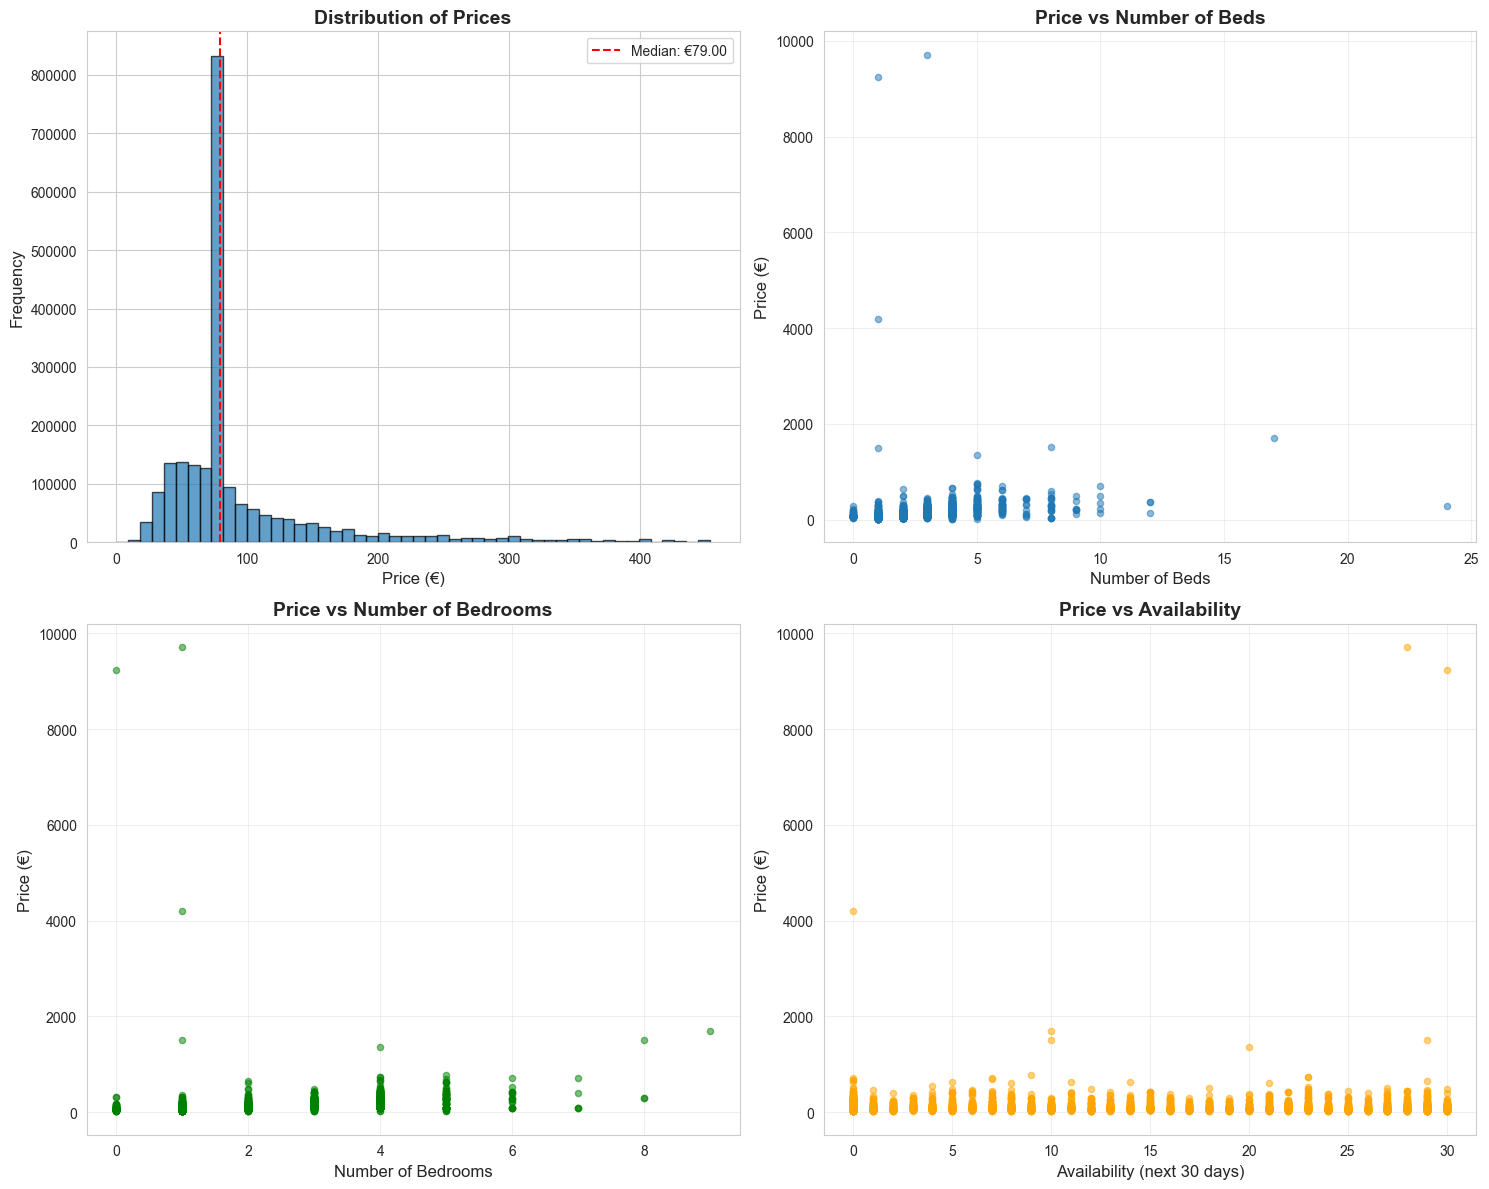

In [123]:
# Create visualizations for price distribution and relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Price distribution
# Calculate the 99th percentile cutoff
limit = X_test['price_clean'].quantile(0.99)
axes[0, 0].hist(X_test['price_clean'].dropna(), bins=50, range=(0, limit), 
                edgecolor='black', alpha=0.7)
#axes[0, 0].hist(X_test['price_clean'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Price (€)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Prices', fontsize=14, fontweight='bold')
axes[0, 0].axvline(X_test['price_clean'].median(), color='red', linestyle='--', 
                   label=f'Median: €{X_test["price_clean"].median():.2f}')
axes[0, 0].legend()

# 2. Price vs Beds
if 'beds' in X_test.columns:
    sample_data = X_test.sample(min(5000, len(X_test)), random_state=42)
    axes[0, 1].scatter(sample_data['beds'], sample_data['price_clean'], alpha=0.5, s=20)
    axes[0, 1].set_xlabel('Number of Beds', fontsize=12)
    axes[0, 1].set_ylabel('Price (€)', fontsize=12)
    axes[0, 1].set_title('Price vs Number of Beds', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Price vs Bedrooms
if 'bedrooms' in X_test.columns:
    sample_data = X_test.sample(min(5000, len(X_test)), random_state=42)
    axes[1, 0].scatter(sample_data['bedrooms'], sample_data['price_clean'], alpha=0.5, s=20, color='green')
    axes[1, 0].set_xlabel('Number of Bedrooms', fontsize=12)
    axes[1, 0].set_ylabel('Price (€)', fontsize=12)
    axes[1, 0].set_title('Price vs Number of Bedrooms', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

# 4. Availability vs Price
if 'availability_30' in X_test.columns:
    sample_data = X_test.sample(min(5000, len(X_test)), random_state=42)
    axes[1, 1].scatter(sample_data['availability_30'], sample_data['price_clean'], alpha=0.5, s=20, color='orange')
    axes[1, 1].set_xlabel('Availability (next 30 days)', fontsize=12)
    axes[1, 1].set_ylabel('Price (€)', fontsize=12)
    axes[1, 1].set_title('Price vs Availability', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2. Interactive Price Optimization Tool

This interactive tool allows you to input listing features and find the optimal price that maximizes expected revenue.

In [122]:
def create_interactive_pricing_tool(listing_features, model, price_range_factor=0.4, n_points=100):
    """
    Create an interactive visualization for price optimization.
    
    Parameters:
    - listing_features: dict or pandas Series with listing features
    - model: trained model for booking probability prediction
    - price_range_factor: factor to determine price range (0.4 = ±40%)
    - n_points: number of price points to evaluate
    """
    # Convert dict to Series if needed
    if isinstance(listing_features, dict):
        # Create a row matching X_test structure
        row = X_test.iloc[0].copy()
        for key, value in listing_features.items():
            if key in row.index:
                row[key] = value
        listing_features = row
    
    base_price = float(listing_features['price_clean'])
    price_grid = np.linspace(
        (1 - price_range_factor) * base_price,
        (1 + price_range_factor) * base_price,
        n_points
    )
    
    # Get predictions
    curve = simulate_pricing_curve(row=listing_features, model=model, price_grid=price_grid, price_col='price_clean')
    print(curve)
    curve['expected_revenue'] = curve['price'] * curve['booking_prob']
    
    # Find optimal price
    optimal_idx = curve['expected_revenue'].idxmax()
    optimal_price = curve.loc[optimal_idx, 'price']
    optimal_prob = curve.loc[optimal_idx, 'booking_prob']
    optimal_revenue = curve.loc[optimal_idx, 'expected_revenue']
    
    # Create interactive plot
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Booking Probability vs Price', 'Expected Revenue vs Price'),
        vertical_spacing=0.15,
        row_heights=[0.5, 0.5]
    )
    
    # Booking probability plot
    fig.add_trace(
        go.Scatter(
            x=curve['price'],
            y=curve['booking_prob'],
            mode='lines',
            name='Booking Probability',
            line=dict(color='blue', width=2),
            hovertemplate='Price: €%{x:.2f}<br>Probability: %{y:.3f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Mark optimal point on probability plot
    fig.add_trace(
        go.Scatter(
            x=[optimal_price],
            y=[optimal_prob],
            mode='markers',
            name='Optimal Price',
            marker=dict(color='red', size=15, symbol='star'),
            hovertemplate='Optimal Price: €%{x:.2f}<br>Probability: %{y:.3f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Expected revenue plot
    fig.add_trace(
        go.Scatter(
            x=curve['price'],
            y=curve['expected_revenue'],
            mode='lines',
            name='Expected Revenue',
            line=dict(color='green', width=2),
            hovertemplate='Price: €%{x:.2f}<br>Expected Revenue: €%{y:.2f}<extra></extra>'
        ),
        row=2, col=1
    )
    
    # Mark optimal point on revenue plot
    fig.add_trace(
        go.Scatter(
            x=[optimal_price],
            y=[optimal_revenue],
            mode='markers',
            name='Optimal Price',
            marker=dict(color='red', size=15, symbol='star'),
            showlegend=False,
            hovertemplate='Optimal Price: €%{x:.2f}<br>Expected Revenue: €%{y:.2f}<extra></extra>'
        ),
        row=2, col=1
    )
    
    # Update layout
    fig.update_xaxes(title_text="Price (€)", row=1, col=1)
    fig.update_yaxes(title_text="Booking Probability", row=1, col=1)
    fig.update_xaxes(title_text="Price (€)", row=2, col=1)
    fig.update_yaxes(title_text="Expected Revenue (€)", row=2, col=1)
    
    fig.update_layout(
        title=f'Interactive Price Optimization Tool<br><sub>Optimal Price: €{optimal_price:.2f} | '
              f'Booking Probability: {optimal_prob:.3f} | Expected Revenue: €{optimal_revenue:.2f}</sub>',
        height=800,
        hovermode='x unified',
        showlegend=True
    )
    
    return fig, optimal_price, optimal_prob, optimal_revenue

# Example: Use a sample listing
sample_row = X_test.sample(1, random_state=42).iloc[0]
fig, opt_price, opt_prob, opt_rev = create_interactive_pricing_tool(sample_row, cal_sigmoid)
fig.show()

         price  booking_prob  expected_revenue
0    47.400000      0.582817         27.625539
1    48.038384      0.582394         27.977261
2    48.676768      0.582394         28.349052
3    49.315152      0.582648         28.733394
4    49.953535      0.582648         29.105347
..         ...           ...               ...
95  108.046465      0.652901         70.543608
96  108.684848      0.652901         70.960409
97  109.323232      0.651424         71.215829
98  109.961616      0.651424         71.631688
99  110.600000      0.651424         72.047547

[100 rows x 3 columns]


### 3. Price Optimization Summary Dashboard

A comprehensive dashboard showing key metrics and optimal pricing recommendations.

In [124]:
# Create a summary dashboard for multiple listings
sample_listings = X_test.sample(min(20, len(X_test)), random_state=42)

results = []
for idx, row in sample_listings.iterrows():
    base_price = float(row['price_clean'])
    price_grid = np.linspace(0.6 * base_price, 1.4 * base_price, 50)
    
    curve = simulate_pricing_curve(row=row, model=cal_sigmoid, price_grid=price_grid, price_col='price_clean')
    optimal_idx = curve['expected_revenue'].idxmax()
    
    optimal_price = curve.loc[optimal_idx, 'price']
    optimal_prob = curve.loc[optimal_idx, 'booking_prob']
    optimal_revenue = curve.loc[optimal_idx, 'expected_revenue']
    
    base_prob = cal_sigmoid.predict_proba(pd.DataFrame([row]))[:, 1][0]
    base_revenue = base_price * base_prob
    
    price_change_pct = ((optimal_price - base_price) / base_price) * 100
    revenue_uplift_pct = ((optimal_revenue - base_revenue) / (base_revenue + 1e-9)) * 100
    
    results.append({
        'base_price': base_price,
        'optimal_price': optimal_price,
        'price_change_pct': price_change_pct,
        'base_revenue': base_revenue,
        'optimal_revenue': optimal_revenue,
        'revenue_uplift_pct': revenue_uplift_pct,
        'optimal_prob': optimal_prob,
        'beds': row.get('beds', 0),
        'bedrooms': row.get('bedrooms', 0),
        'availability_30': row.get('availability_30', 0)
    })

results_df = pd.DataFrame(results)

# Create interactive dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Price Change Distribution',
        'Revenue Uplift Distribution',
        'Optimal Price vs Base Price',
        'Revenue Uplift vs Price Change'
    ),
    specs=[[{"type": "histogram"}, {"type": "histogram"}],
           [{"type": "scatter"}, {"type": "scatter"}]]
)

# Price change distribution
fig.add_trace(
    go.Histogram(x=results_df['price_change_pct'], nbinsx=20, name='Price Change %',
                 marker_color='blue'),
    row=1, col=1
)

# Revenue uplift distribution
fig.add_trace(
    go.Histogram(x=results_df['revenue_uplift_pct'], nbinsx=20, name='Revenue Uplift %',
                 marker_color='green'),
    row=1, col=2
)

# Optimal vs Base price
fig.add_trace(
    go.Scatter(
        x=results_df['base_price'],
        y=results_df['optimal_price'],
        mode='markers',
        name='Listings',
        marker=dict(size=8, opacity=0.6, color='purple'),
        hovertemplate='Base: €%{x:.2f}<br>Optimal: €%{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Add diagonal line
max_price = max(results_df['base_price'].max(), results_df['optimal_price'].max())
fig.add_trace(
    go.Scatter(x=[0, max_price], y=[0, max_price], mode='lines',
               name='No Change', line=dict(dash='dash', color='red')),
    row=2, col=1
)

# Revenue uplift vs price change
fig.add_trace(
    go.Scatter(
        x=results_df['price_change_pct'],
        y=results_df['revenue_uplift_pct'],
        mode='markers',
        name='Listings',
        marker=dict(size=8, opacity=0.6, color='orange'),
        hovertemplate='Price Change: %{x:.1f}%<br>Revenue Uplift: %{y:.1f}%<extra></extra>'
    ),
    row=2, col=2
)

# Update axes
fig.update_xaxes(title_text="Price Change (%)", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_xaxes(title_text="Revenue Uplift (%)", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=2)
fig.update_xaxes(title_text="Base Price (€)", row=2, col=1)
fig.update_yaxes(title_text="Optimal Price (€)", row=2, col=1)
fig.update_xaxes(title_text="Price Change (%)", row=2, col=2)
fig.update_yaxes(title_text="Revenue Uplift (%)", row=2, col=2)

fig.update_layout(
    title='Price Optimization Summary Dashboard',
    height=900,
    showlegend=True
)

fig.show()

# Print summary statistics
print("\n=== Price Optimization Summary ===")
print(f"Average price change: {results_df['price_change_pct'].mean():.2f}%")
print(f"Average revenue uplift: {results_df['revenue_uplift_pct'].mean():.2f}%")
print(f"Median price change: {results_df['price_change_pct'].median():.2f}%")
print(f"Median revenue uplift: {results_df['revenue_uplift_pct'].median():.2f}%")
print(f"\nListings with positive revenue uplift: {(results_df['revenue_uplift_pct'] > 0).sum()}/{len(results_df)}")
print(f"Listings with >10% revenue uplift: {(results_df['revenue_uplift_pct'] > 10).sum()}/{len(results_df)}")


=== Price Optimization Summary ===
Average price change: 39.84%
Average revenue uplift: 37.36%
Median price change: 40.00%
Median revenue uplift: 39.36%

Listings with positive revenue uplift: 20/20
Listings with >10% revenue uplift: 20/20
